In [ ]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from src.models.TRANSFORMER import TransformerClassifier
from src.models.LSTM import LSTMClassifier
from transformers import BertModel
from src.local_datasets.goemotions import GoEmotionsDataset
from src.local_datasets.yelp import YelpDataset
from torch.utils.data import DataLoader
from torch.nn import functional as F


# DATASETS 

In [ ]:
yelp_pytorch = YelpDataset(split="train")
yelp_dataloaders = torch.utils.data.DataLoader(yelp_pytorch, batch_size=len(yelp_pytorch), shuffle=False)
yelp_data = next(iter(yelp_dataloaders))


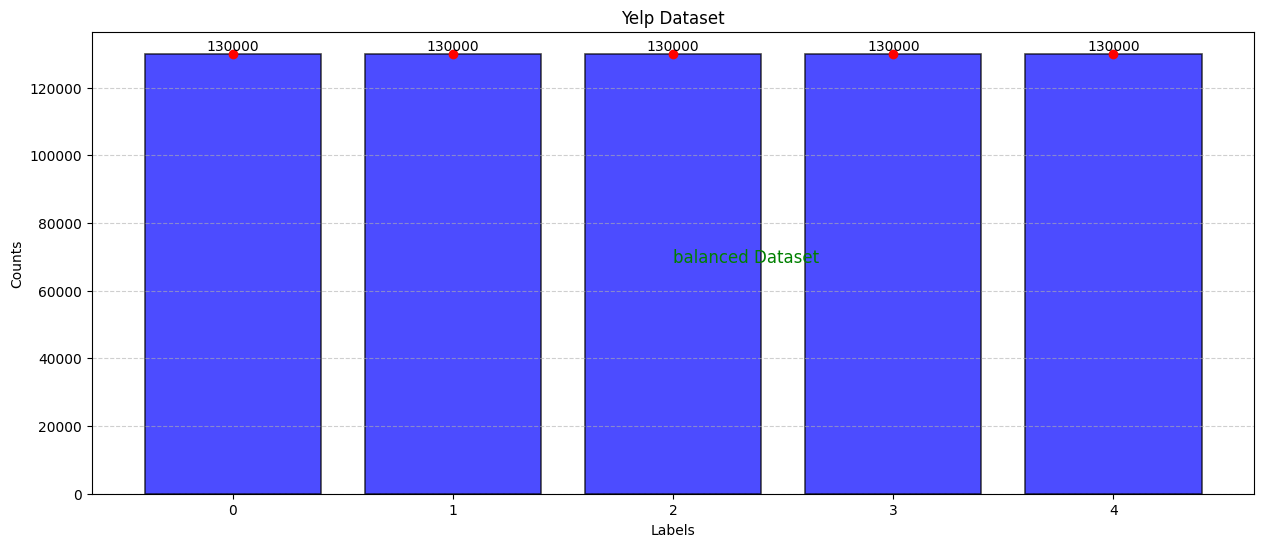

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json


plt.figure(figsize=(15, 6))
_, labels,_ = yelp_data
label_counts = Counter(labels.numpy())
bars = plt.bar(label_counts.keys(), label_counts.values(),
        color='b',
        alpha=0.7,
        align='center',
        edgecolor='black',
        linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.annotate('balanced Dataset',
             xy=(0.5, 0.5), xytext=(0.5, 0.5), 
             textcoords='axes fraction', fontsize=12, 
             color='g')

plt.scatter(label_counts.keys(),
            label_counts.values(), 
            color='red')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}', ha='center', va='bottom')

plt.title('Yelp Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(ticks=np.arange(5),)
plt.show()



In [ ]:
goemotions_pytorch = GoEmotionsDataset(split="train")
ge_dataloaders = torch.utils.data.DataLoader(goemotions_pytorch, batch_size=len(goemotions_pytorch), shuffle=False)
goemotions_data = next(iter(ge_dataloaders))


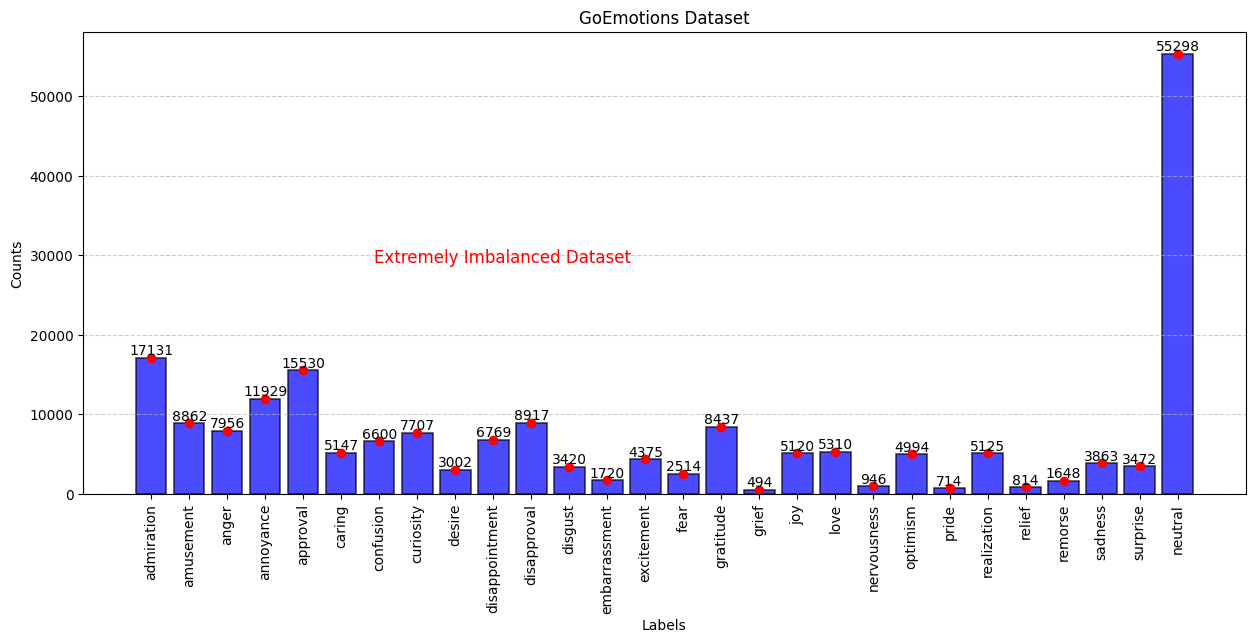

207814


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json

with open('data/goemotions_labels.json') as f:
    label_names = json.load(f)['names']

_ , labels , _ = goemotions_data
label_counts = Counter(labels.numpy())

plt.figure(figsize=(15, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(),
        color='b',
        alpha=0.7,
        align='center',
        edgecolor='black',
        linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.annotate('Extremely Imbalanced Dataset',
             xy=(0.5, 0.5), xytext=(0.25, 0.5), 
             textcoords='axes fraction', fontsize=12, 
             color='red')

plt.scatter(label_counts.keys(),
            label_counts.values(), 
            color='red')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}', ha='center', va='bottom')

plt.title('GoEmotions Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=90)
plt.show()
print(len(goemotions_pytorch))

#### Train Random Forest Classifier ON YELP

In [ ]:
from src.models.RFC import  RandomForestClassifier
from src.utils.helpers import load_from_disk, create_splits

path = "data/yelp_to_emotions.json"
new_yelp = load_from_disk(path)
train_data, train_labels, test_data, test_labels = create_splits(new_yelp)
rfc = RandomForestClassifier(n_jobs=32)
rfc.fit(train_data, train_labels)
preds = rfc.predict(test_data)


In [8]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60      9816
           1       0.34      0.34      0.34      9856
           2       0.33      0.30      0.31      9849
           3       0.36      0.32      0.34      9871
           4       0.50      0.53      0.51      9760

    accuracy                           0.43     49152
   macro avg       0.42      0.43      0.42     49152
weighted avg       0.42      0.43      0.42     49152



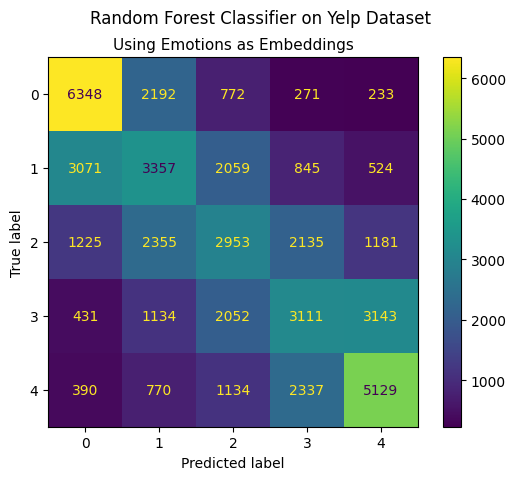

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.suptitle("Random Forest Classifier on Yelp Dataset", fontsize=12)
plt.title("Using Emotions as Embeddings", fontsize=11)
plt.show()